In [21]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

from torchinfo import summary

In [22]:
class VRLoss(nn.Module):

    def __init__(self, w_cos1 = 1., w_cos2 = 1., w_l2 = 2.) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.l2 = nn.MSELoss()
        s = w_cos1 + w_cos2 + w_l2
        self.w_cos1, self.w_cos2, self.w_l2 = w_cos1/s, w_cos2/s, w_l2/s

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = -self.cosinesim1(output, target)
        sim2 = -self.cosinesim2(output, target)
        l2 = self.l2(output, target)

        l = self.w_cos1*(sim1.exp().mean()-1e-1) + self.w_cos2*(sim2.exp().mean()-1e-1) + self.w_l2*l2
        
        return l

In [42]:
dataset = EncoderDecoderStaticDataset('/home/shivampr21/DKLabs/OilGasProject/WellLogCorrelation/data', patch_size=100, sig_smoothening=1)
dataset.dataset.wells_list = dataset.dataset.wells_list.repeat(10)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True, num_workers = 6)
data_len = len(dataloader)
log_n = int(data_len//2)

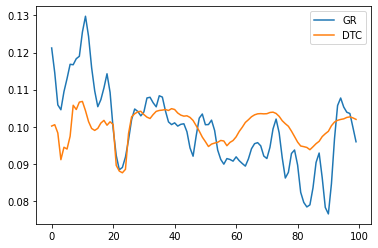

In [43]:
sample_data = dataset[2]
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [44]:
sample_data.shape

torch.Size([2, 100])

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
model = EncoderDecoder1DCNN(2, 50, size=100, activation=nn.SELU, norm_layer=None)
model.to(device)
# model.load_state_dict(torch.load('./modelstate_vr_loss_l2_dominated_Well_set_32'))
model.train()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): Conv1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): Conv1d(5, 2, kernel_size=(10,), stride=(1,))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(2, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): Conv1d(5, 2, kernel_size=(5,), stride=(1,))
  )
)

In [47]:
sample_data.shape

torch.Size([2, 100])

In [48]:
summary(model, (11, 2, 100))

Layer (type:depth-idx)                   Output Shape              Param #
EncoderDecoder1DCNN                      --                        --
├─Sequential: 1-1                        [11, 2, 55]               --
│    └─Conv1d: 2-1                       [11, 5, 91]               105
│    └─SELU: 2-2                         [11, 5, 91]               --
│    └─Conv1d: 2-3                       [11, 10, 82]              510
│    └─SELU: 2-4                         [11, 10, 82]              --
│    └─Conv1d: 2-5                       [11, 10, 73]              1,010
│    └─SELU: 2-6                         [11, 10, 73]              --
│    └─Conv1d: 2-7                       [11, 5, 64]               505
│    └─SELU: 2-8                         [11, 5, 64]               --
│    └─Conv1d: 2-9                       [11, 2, 55]               102
├─Sequential: 1-2                        [11, 2, 82]               --
│    └─ConvTranspose1d: 2-10             [11, 5, 59]               105
│    └─

In [49]:
criterion =  VRLoss(w_cos1=0.0, w_cos2=1.0, w_l2=2.0) # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.00001, weight_decay=0.0000001)

In [50]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [51]:
rll = []
total_loss = []

In [52]:
model.train()
total_loss += [compute_loss(dataloader, model, criterion)]
print(f'Total loss : {total_loss[-1]}')
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Total loss : 0.4829347846459369
Epoch : 0, Iteration : 3,Running loss : 0.48331449925899506
Epoch : 0, Iteration : 7,Running loss : 0.47735263407230377
Total loss : 0.4817405312645192
Epoch : 1, Iteration : 3,Running loss : 0.4792425334453583
Epoch : 1, Iteration : 7,Running loss : 0.4812173992395401


KeyboardInterrupt: 

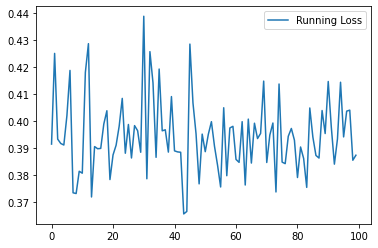

In [35]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

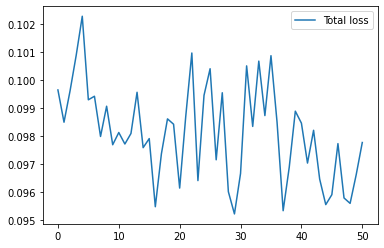

In [36]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [37]:
torch.save(model.state_dict(), './modelstate_vr_loss_l2_dominated_nt3')

In [38]:
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): Conv1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): Conv1d(5, 2, kernel_size=(10,), stride=(1,))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(2, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): Conv1d(5, 2, kernel_size=(5,), stride=(1,))
  )
)

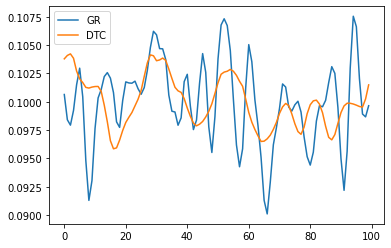

In [39]:
sample_data = dataset[11]
# sample_data[0, :] = torch.from_numpy(np.convolve(sample_data[0, :].numpy(), np.ones(5), mode='same'))
# sample_data[1, :] = torch.from_numpy(np.convolve(sample_data[1, :].numpy(), np.ones(5), mode='same'))
# sample_data = sample_data[:, 4:-5]
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [40]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

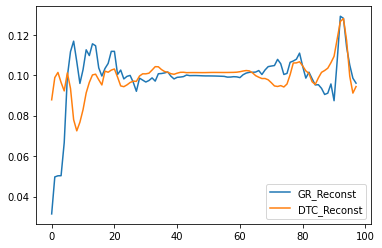

In [41]:
plt.plot(reconst_data[1, :-2], label='GR_Reconst')
plt.plot(reconst_data[0, :-2], label='DTC_Reconst')
plt.legend()
plt.show()

In [37]:
reconst_data.shape

(2, 100)